In [53]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, time_diff, train

eeg_data_1 = pd.read_csv('data/subject2/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject2/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject2/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject2/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject2/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject2/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [54]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated
Gradcpt data had to be truncated


### z-normalization

In [55]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [56]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [57]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

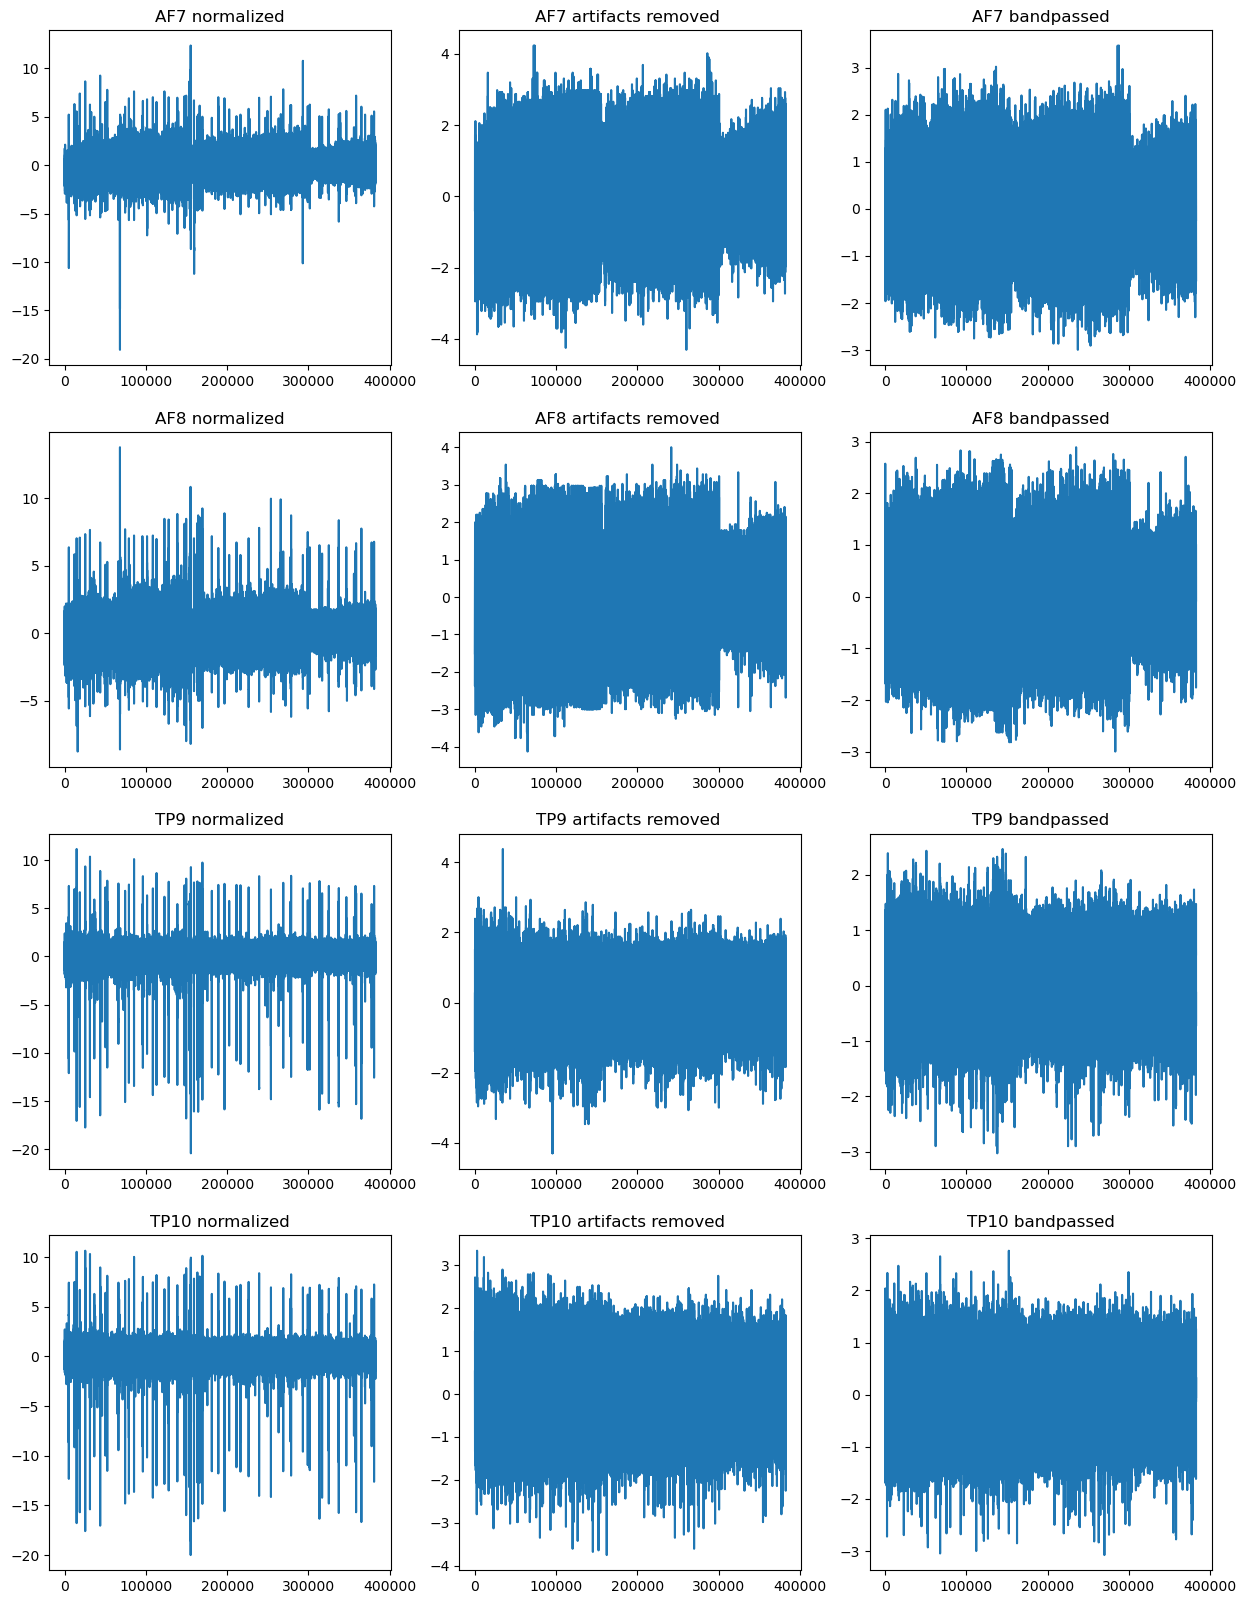

In [58]:
plt.figure(figsize=(15,20))

for i, channel in enumerate(channels):
    plt.subplot(4, 3, i*3+1)
    plt.plot(eeg_data[f'{channel}_normal'], label=f'{channel} normalized')
    plt.title(f'{channel} normalized')

    plt.subplot(4, 3, i*3+2)
    plt.plot(eeg_data[f'{channel}_artif_removed'], label=f'{channel} artifacts removed')
    plt.title(f'{channel} artifacts removed ')

    plt.subplot(4, 3, i*3+3)
    plt.plot(eeg_data[f'{channel}_bandpassed'], label=f'{channel} bandpassed')
    plt.title(f'{channel} bandpassed')

### Separate trials

In [59]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

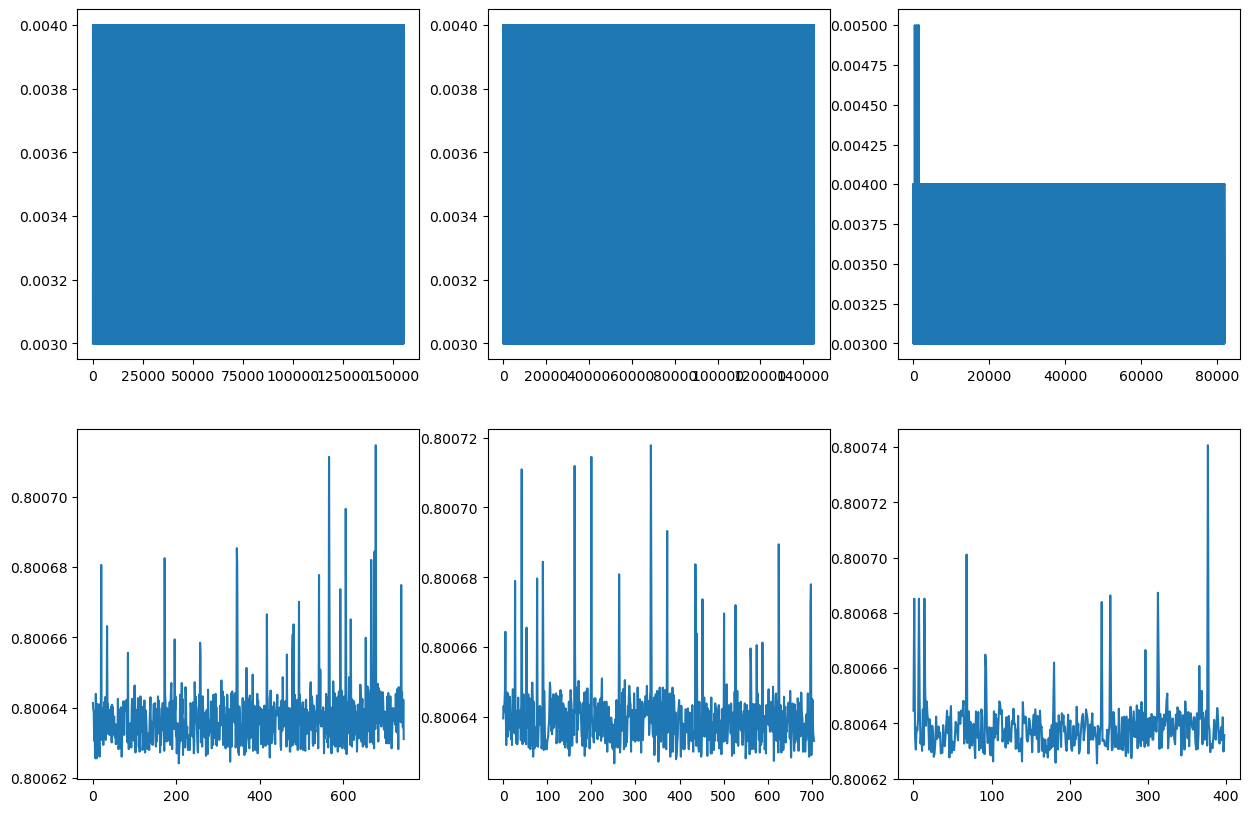

In [60]:
def trial_length(arr):
    diffs = []
    for i in range(1, len(arr)):
        diffs.append(arr[i] - arr[i-1])
    return diffs

plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
plt.plot(trial_length(eeg_data_t1['timestamps']))

plt.subplot(2, 3, 2)
plt.plot(trial_length(eeg_data_t2['timestamps']))

plt.subplot(2, 3, 3)
plt.plot(trial_length(eeg_data_t3['timestamps']))

plt.subplot(2, 3, 4)
plt.plot(trial_length(gradcpt_data_t1['start_timestamp']))

plt.subplot(2, 3, 5)
plt.plot(trial_length(gradcpt_data_t2['start_timestamp']))

plt.subplot(2, 3, 6)
plt.plot(trial_length(gradcpt_data_t3['start_timestamp']))


In [61]:
diffs_t1 = time_diff(eeg_data_1, gradcpt_data_1)
diffs_t2 = time_diff(eeg_data_t2, gradcpt_data_t2)
diffs_t3 = time_diff(eeg_data_t3, gradcpt_data_t3)

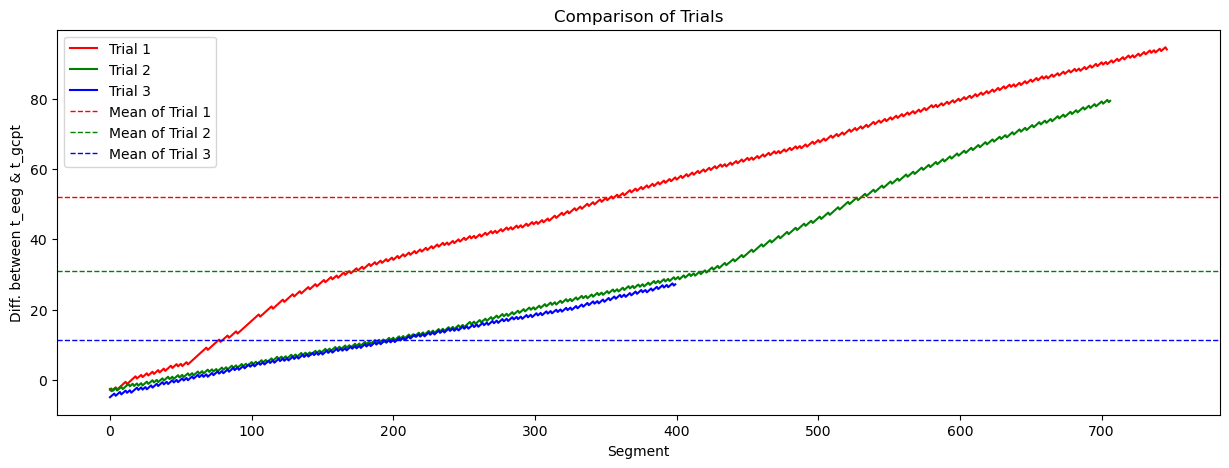

Avg. diff in segment in trial 1: 0.0695869526044857
Avg. diff in segment in trial 2: 0.043780309112916305
Avg. diff in segment in trial 3: 0.028159354627132416


In [62]:
plt.figure(figsize=(15, 5))

plt.plot(diffs_t1, label='Trial 1',  color='r')
plt.plot(diffs_t2, label='Trial 2',  color='g')
plt.plot(diffs_t3, label='Trial 3',  color='b')

# Calculate means
mean_t1 = np.mean(diffs_t1)
mean_t2 = np.mean(diffs_t2)
mean_t3 = np.mean(diffs_t3)

# Plot means
plt.axhline(y=mean_t1, color='r', linestyle='--', label='Mean of Trial 1', linewidth=1)
plt.axhline(y=mean_t2, color='g', linestyle='--', label='Mean of Trial 2', linewidth=1)
plt.axhline(y=mean_t3, color='b', linestyle='--', label='Mean of Trial 3', linewidth=1)

plt.title('Comparison of Trials')
plt.xlabel('Segment')
plt.ylabel('Diff. between t_eeg & t_gcpt')
plt.legend()

plt.show()

print(f'Avg. diff in segment in trial 1: {mean_t1/len(diffs_t1)}')
print(f'Avg. diff in segment in trial 2: {mean_t2/len(diffs_t2)}')
print(f'Avg. diff in segment in trial 3: {mean_t3/len(diffs_t3)}')

### Extract features

In [63]:
combined_eeg_df = pd.concat([eeg_data_t1, eeg_data_t2, eeg_data_t3], ignore_index=True)
combined_gradcpt_df = pd.concat([gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3], ignore_index=True)

In [64]:
import numpy as np

all_channel_segments = []

# Process each channel
for channel in channels:
    # Segment the current EEG data for the channel
    channel_segments = segment_column(combined_eeg_df[f'{channel}_bandpassed'], combined_gradcpt_df)
    
    # Convert the list of segments into a numpy array with shape (number of segments, 205)
    # Notice we're not introducing the singleton dimension this time
    channel_segments_array = np.array(channel_segments).reshape(-1, 205)
    
    # Append the reshaped segments for this channel to the list
    all_channel_segments.append(channel_segments_array)

# Stack the channel segments along a new axis to combine them
# This should result in a shape: (number of segments, number of channels, 205)
combined_segments = np.stack(all_channel_segments, axis=1)
labels = np.array(combined_gradcpt_df['in_the_zone'])

# Now the shape should be (743, 4, 205) for 743 segments, 4 channels, and 205 time points per segment
print(f"Corrected combined segments shape: {combined_segments.shape}")
print(f"Labels shape: {labels.shape}")

Corrected combined segments shape: (1854, 4, 205)
Labels shape: (1854,)


## Detach rocket

### Train and eval

In [65]:
from detach_rocket.detach_rocket.detach_classes import DetachRocket
from sklearn.model_selection import train_test_split

X = combined_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = DetachRocket(model_type='minirocket', num_kernels=10000)
model.fit(X_train, y_train)

#Evaluate Performance on Test Set
detach_test_score, full_test_score= model.score(X_test,y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach-ROCKET: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 74.10%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 119.00
Train Accuraccy Detach Model: 60.63%
-------------------------
Test Accuraccy Full Model: 55.56%
Test Accuraccy Detach-ROCKET: 54.48%


### Plot SFD Curve and Optimal Model selection

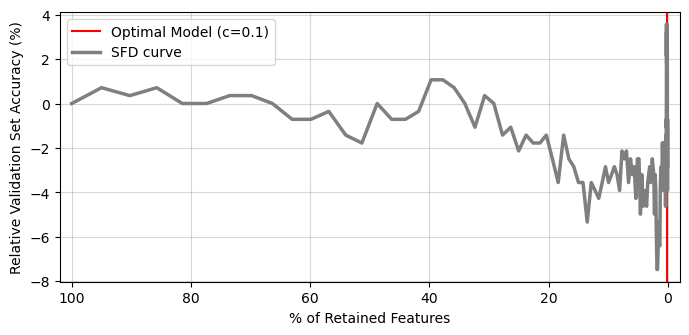

Optimal Model Size: 0.22% of full model


In [66]:
percentage_vector = model._percentage_vector
acc_curve = model._sfd_curve

c = model.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100
point_x = x[model._max_index]
#point_y = y[model._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

### 4 preciding windows

In [67]:
import numpy as np

# Assuming 'combined_segments' has the shape (743, 4, 205)
# Initialize a list to hold the new aggregated segments
new_segments = []

# Loop through the segments, starting from the 4th one
for i in range(4, len(combined_segments)):
    # Initialize a list to hold the concatenated segments for all channels
    concatenated_segments_all_channels = []

    # Loop through each channel
    for channel in range(4):
        # Concatenate the current segment with its 4 preceding segments for this channel
        concatenated_segment = np.concatenate(combined_segments[i-4:i+1, channel, :], axis=0)
        concatenated_segments_all_channels.append(concatenated_segment)

    # Stack the concatenated segments for all channels
    # This results in a shape: (4, 1025) for each new aggregated segment
    new_segment = np.stack(concatenated_segments_all_channels, axis=0)
    new_segments.append(new_segment)

# Convert the list of new segments to a numpy array
new_segments = np.array(new_segments)

# The shape will be (739, 4, 1025) since we start from the 4th original segment
print(f"New segments shape: {new_segments.shape}")

New segments shape: (1850, 4, 1025)


In [81]:
from detach_rocket.detach_rocket.detach_classes import DetachRocket
from sklearn.model_selection import train_test_split

X = combined_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = DetachRocket(model_type='minirocket', num_kernels=10000)
model.fit(X_train, y_train)

#Evaluate Performance on Test Set
detach_test_score, full_test_score= model.score(X_test,y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach-ROCKET: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 73.71%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 118.00
Train Accuraccy Detach Model: 59.75%
-------------------------
Test Accuraccy Full Model: 55.91%
Test Accuraccy Detach-ROCKET: 53.76%


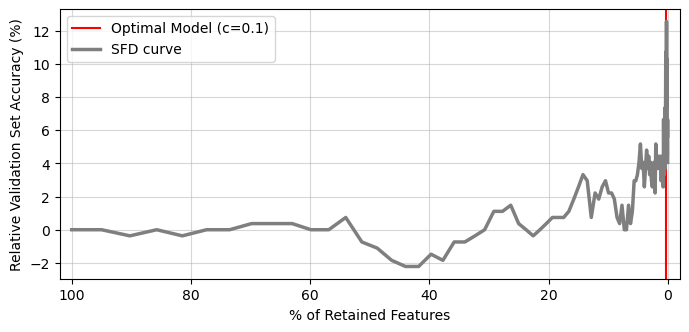

Optimal Model Size: 0.23% of full model


In [82]:
percentage_vector = model._percentage_vector
acc_curve = model._sfd_curve

c = model.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100
point_x = x[model._max_index]
#point_y = y[DetachRocketModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

In [80]:
X_transformed = model.transform_features(X)
y = labels

In [76]:
from sklearn.preprocessing import StandardScaler
def train(runs):
    results = []
    
    for _ in range(runs):
        from scipy.stats import ttest_ind
        from sklearn.model_selection import StratifiedKFold, GridSearchCV
        from sklearn.metrics import balanced_accuracy_score
        from sklearn.svm import SVC
        
        features = X_transformed
        labels = y
        
        outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
        
        balanced_acc_scores = []
        
        for train_index, test_index in outer_cv.split(features, labels):
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        
            # Inner CV for hyperparameter tuning
            inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            param_grid = {'C': [0.1, 0.5, 1], 'gamma': ['scale'], 'kernel': ['rbf']}
            grid_search = GridSearchCV(SVC(), param_grid, cv=inner_cv, scoring='balanced_accuracy')
            grid_search.fit(X_train, y_train)
        
            best_model = grid_search.best_estimator_
            
            balanced_acc = balanced_accuracy_score(y_test, best_model.predict(X_test))
            balanced_acc_scores.append(balanced_acc)
        
        final_performance = np.mean(balanced_acc_scores)
        results.append(round(final_performance, 3))
    
    print(f'Avg: {round((sum(results) / len(results)) * 100, 3)}%')

In [77]:
train(runs=5)

Avg: 57.64%
